# Udacity Vehicle Detection

In [110]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pickle
import cv2
import glob
import time
import math

from moviepy.editor import VideoFileClip

from scipy.ndimage.measurements import label

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

print('done')

done


In [113]:
def plotImages(images, titles, cmap=False):
    '''
    Plots the images and the assosiated titles
    '''

    def closestDivisors(n):
        a = round(math.sqrt(n))
        while n%a > 0: a -= 1
        return a,n//a
    
    # prepare figure for plotting the results
    size = closestDivisors(len(images))
    figure, axis = plt.subplots(size[0], size[1], figsize=(15, 10))
    figure.subplots_adjust(hspace=0.1, wspace=0.1)
    axis = axis.ravel()
    
    for i in range(len(images)):
        if cmap:
            axis[i].imshow(images[i], cmap=cmap)
        else:
            axis[i].imshow(images[i])
        axis[i].set_title(titles[i])
        axis[i].axis('off')
        
    figure.savefig('test.png')

## Load the Data

In [114]:
carImages = glob.glob('./vehicles/**/*.png')
nonCarImages = glob.glob('./non-vehicles/**/*.png')
print(len(carImages), len(nonCarImages))

8792 8968


## Visualise Random Images

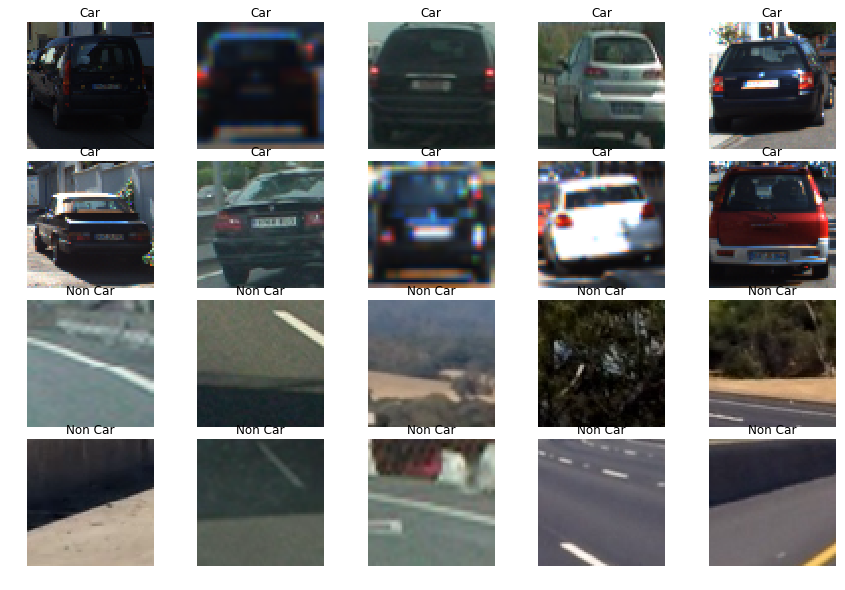

In [115]:
sampleImages = [cv2.cvtColor(cv2.imread(carImages[np.random.randint(0, len(carImages))]), cv2.COLOR_BGR2RGB) 
                for i in range(10)]
sampleImages += [cv2.cvtColor(cv2.imread(nonCarImages[np.random.randint(0, len(nonCarImages))]), cv2.COLOR_BGR2RGB) 
                 for i in range(10)]
sampleTitles = ['Car' for i in range(10)]
sampleTitles += ['Non Car' for i in range(10)]
plotImages(sampleImages, sampleTitles)

## Pick random image to work with from each group

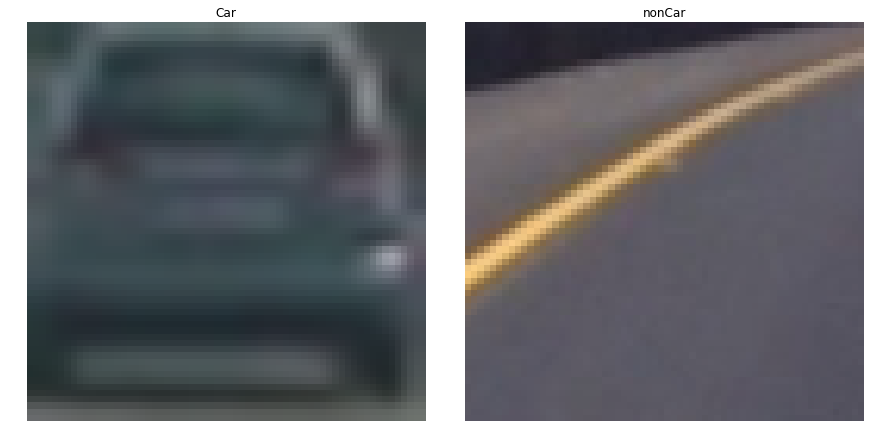

In [116]:
testCar = cv2.cvtColor(cv2.imread(carImages[10]), cv2.COLOR_BGR2RGB)
testNonCar = cv2.cvtColor(cv2.imread(nonCarImages[10]), cv2.COLOR_BGR2RGB)

plotImages([testCar, testNonCar], ['Car', 'nonCar'])

## Histogram of Oriented Gradient (HOG)

In [117]:
def getHogFeatures(image, orient, pixPerCell, cellPerBlock, vis=False, featureVec=True):
    
    if vis == True:
        features, hogImage = hog(image, orientations=orient, pixels_per_cell=(pixPerCell, pixPerCell),
                                  cells_per_block=(cellPerBlock, cellPerBlock), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hogImage
    else:      
        features = hog(image, orientations=orient, pixels_per_cell=(pixPerCell, pixPerCell),
                       cells_per_block=(cellPerBlock, cellPerBlock), transform_sqrt=False, 
                       visualise=False, feature_vector=featureVec)
        return features

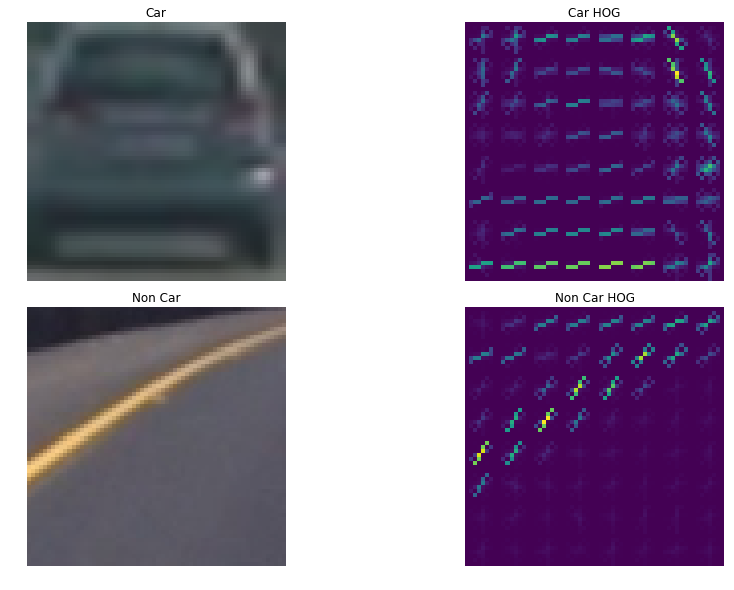

In [119]:
_, testCarHog = getHogFeatures(testCar[:,:,2], 9, 8, 2, vis=True, featureVec=True)
_, testNonCarHog = getHogFeatures(testNonCar[:,:,2], 9, 8, 2, vis=True, featureVec=True)

plotImages([testCar, testCarHog, testNonCar, testNonCarHog], ['Car', 'Car HOG', 'Non Car', 'Non Car HOG'])

## Extract HOG Features

In [28]:
def extractFeatures(images, cspace='RGB', orient=9, pixPerCell=8, cellPerBlock=2, hogChannel=0):
    features = []
    
    for file in images:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: 
            featureImage = np.copy(image)
            
        if hogChannel == 'all':
            hogFeatures = []
            for channel in range(featureImage.shape[2]):
                hogFeatures.append(
                    getHogFeatures(
                        featureImage[:,:,channel], 
                        orient, 
                        pixPerCell, 
                        cellPerBlock, 
                        vis=False, 
                        featureVec=True
                    )
                )
            hogFeatures = np.ravel(hogFeatures)
        else:
            hogFeatures = getHogFeatures(
                featureImage[:,:,hogChannel], 
                orient, 
                pixPerCell, 
                cellPerBlock, 
                vis=False, 
                featureVec=True
            )
            
        features.append(hogFeatures)
    return features

## Extract Features for Dataset

In [93]:
# cspace = 'YUV'
# orient = 11
# pixPerCell = 16
# cellPerBlock = 2
# hogChannel = 'all'

carImages = glob.glob('./vehicles/**/*.png')
nonCarImages = glob.glob('./non-vehicles/**/*.png')

cspace = 'YUV'
orient = 11
pixPerCell = 8
cellPerBlock = 2
hogChannel = 'all'

t1 = time.time()
carFeatures = extractFeatures(
    carImages, 
    cspace=cspace, 
    orient=orient, 
    pixPerCell=pixPerCell, 
    cellPerBlock=cellPerBlock, 
    hogChannel=hogChannel
)
nonCarFeatures = extractFeatures(
    nonCarImages, 
    cspace=cspace, 
    orient=orient, 
    pixPerCell=pixPerCell, 
    cellPerBlock=cellPerBlock, 
    hogChannel=hogChannel
)
t2 = time.time()
print(round(t2-t1, 2), ' seconds for HOG extraction')

X = np.vstack((carFeatures, nonCarFeatures)).astype(np.float64)
y = np.hstack((np.ones(len(carFeatures)), np.zeros(len(nonCarFeatures))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train features length: ', len(X_train))
print('Test features length: ', len(X_test))

124.74  seconds for HOG extraction
Train features length:  14208
Test features length:  3552


## Train Classifier

In [94]:
svc = LinearSVC()

t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 1), ' seconds for training.')

print('Accuracy: ', round(svc.score(X_test, y_test), 4))

16.5  seconds for training.
Accuracy:  0.9828


Label | Colour Space| Orientaion | Pixels Per Cell | Cell Per Block | HOG Channel | Accuracy  | Extract Time
------| ----------- |----------  | ----------------| ---------------| ----------- | ----------| -------------
1     |    RGB      |      9     |         8       |       2        |     all     |   0.9758  |   215.23
2     |    HSV      |      9     |         8       |       2        |      1      |   0.9186  |    96.75
3     |    HSV      |      9     |         8       |       2        |      2      |   0.9609  |    85.37
4     |    LUV      |      9     |         8       |       2        |      0      |   0.9623  |    79.88
5     |    LUV      |      9     |         8       |       2        |      1      |   0.9406  |    87.34
6     |    HLS      |      9     |         8       |       2        |      0      |   0.9333  |    78.61
7     |    HLS      |      9     |         8       |       2        |      1      |   0.9623  |    73.54
8     |    YUV      |      9     |         8       |       2        |      0      |   0.9651  |    76.66
9     |    YUV      |      9     |         8       |       2        |     all     |   0.9820  |   218.69
10    |    YUV      |      11    |         8       |       2        |     all     |   0.9828  |   233.13
11    |    YUV      |      11    |         16      |       2        |     all     |   0.9814  |    95.61
12    |    YUV      |      5     |         8       |       2        |     all     |   0.9803  |   113.67

## Detect Cars in Image

In [120]:
def detectCars(image, yStart, yStop, scale, 
               csapce, hogChannel, svc, X_scaler, 
               orient, pixPerCell, cellPerBlock, 
               spatialSize, histBins):
    
    image = image.astype(np.float32)/255
    image = image[yStart:yStop,:,:]
    
    rectangles = []
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    if scale != 1:
        image = cv2.resize(image, (np.int(image.shape[1]/scale), np.int(image.shape[0]/scale)))
        
    channel1 = image[:,:,0]
    channel2 = image[:,:,1]
    channel3 = image[:,:,2]
    
    nxBlocks = (channel1.shape[1] // pixPerCell) + 1
    nyBlocks = (channel1.shape[0] // pixPerCell) + 1
    nFeatPerBlock = orient * cellPerBlock**2
    
    window = 64
    nBlocksPerWindow = (window // pixPerCell) - 1
    cellsPerStep = 2
    nxSteps = (nxBlocks - nBlocksPerWindow) // cellsPerStep
    nySteps = (nyBlocks - nBlocksPerWindow) // cellsPerStep
    
    hog1 = getHogFeatures(channel1, orient, pixPerCell, cellPerBlock, featureVec=False)
    if hogChannel == 'all':
        hog2 = getHogFeatures(channel2, orient, pixPerCell, cellPerBlock, featureVec=False)
        hog3 = getHogFeatures(channel3, orient, pixPerCell, cellPerBlock, featureVec=False)
        
    for xb in range(nxSteps):
        for yb in range(nySteps):
            
            yPos = yb * cellsPerStep
            xPos = xb * cellsPerStep
            
            hogFeat1 = hog1[yPos:yPos+nBlocksPerWindow, xPos:xPos+nBlocksPerWindow].ravel()
            if hogChannel == 'all':
                hogFeat2 = hog2[yPos:yPos+nBlocksPerWindow, xPos:xPos+nBlocksPerWindow].ravel()
                hogFeat3 = hog3[yPos:yPos+nBlocksPerWindow, xPos:xPos+nBlocksPerWindow].ravel()
                hogFeatures = np.hstack((hogFeat1, hogFeat2, hogFeat3))
            else:
                hogFeatures = hogFeat1
                
            xLeft = xPos * pixPerCell
            yTop = yPos * pixPerCell
            
            prediction = svc.predict(hogFeatures)
            
            if prediction == 1:
                xBoxLeft = np.int(xLeft * scale)
                yTopDraw = np.int(yTop * scale)
                winDraw = np.int(window * scale)
                rectangles.append(((xBoxLeft, yTopDraw + yStart), (xBoxLeft + winDraw, yTopDraw + winDraw + yStart)))
    
    return rectangles

In [121]:
def drawBoxes(image, bboxes, thick=6):
    
    image = np.copy(image)
    
    for bbox in bboxes:
        color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
        cv2.rectangle(image, bbox[0], bbox[1], color, thick)
    return image

## Find Cars in Test Images

11  cars found.


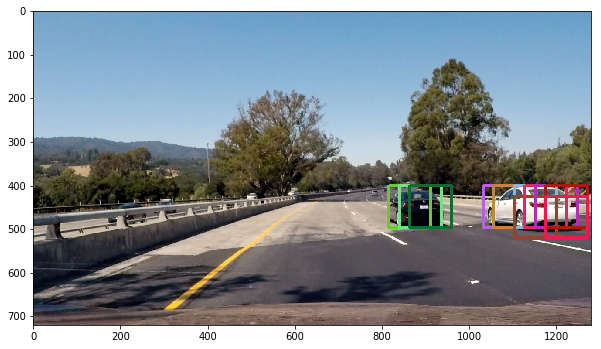

In [123]:
testImage = mpimg.imread('./test_images/test4.jpg')

yStart = 400
yStop = 656
scale = 1.5
cspace = 'YUV'
orient = 11
pixPerCell = 8
cellPerBlock = 2
hogChannel = 'all'

rectangles = detectCars(testImage, yStart, yStop, 
                        scale, cspace, hogChannel, 
                        svc, None, orient, 
                        pixPerCell, cellPerBlock, None, None)

print(len(rectangles), ' cars found.')

testImageRec = drawBoxes(testImage, rectangles)
plt.figure(figsize=(10, 10))
plt.imshow(testImageRec)
plt.savefig('test.png')

## Various Sliding Windows
Since car can show up in different sizes and at different locations will be doing several passes through the image with different window sizes

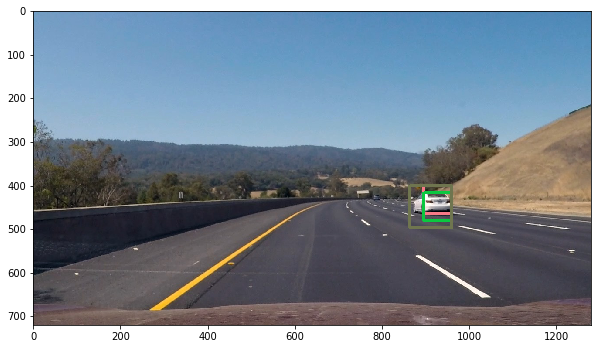

In [198]:
testImage = mpimg.imread('./test_images/test3.jpg')

cspace = 'YUV'
orient = 11
pixPerCell = 8
cellPerBlock = 2
hogChannel = 'all'


yStart = 400
yStop = 464
scale = 1.0
rectangles = detectCars(testImage, yStart, yStop, 
                        scale, cspace, hogChannel, 
                        svc, None, orient, 
                        pixPerCell, cellPerBlock, None, None)

yStart = 416
yStop = 480
scale = 1.0
rectangles += detectCars(testImage, yStart, yStop, 
                        scale, cspace, hogChannel, 
                        svc, None, orient, 
                        pixPerCell, cellPerBlock, None, None)

yStart = 400
yStop = 496
scale = 1.5
rectangles += detectCars(testImage, yStart, yStop, 
                        scale, cspace, hogChannel, 
                        svc, None, orient, 
                        pixPerCell, cellPerBlock, None, None)

yStart = 432
yStop = 528
scale = 1.5
rectangles += detectCars(testImage, yStart, yStop, 
                        scale, cspace, hogChannel, 
                        svc, None, orient, 
                        pixPerCell, cellPerBlock, None, None)

yStart = 400
yStop = 528
scale = 2.0
rectangles += detectCars(testImage, yStart, yStop, 
                        scale, cspace, hogChannel, 
                        svc, None, orient, 
                        pixPerCell, cellPerBlock, None, None)

testImageRec = drawBoxes(testImage, rectangles)
plt.figure(figsize=(10, 10))
plt.imshow(testImageRec)

## Heatmap

In [199]:
def addHeat(image, bboxs):
    
    for bbox in bboxs:
        image[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    return image

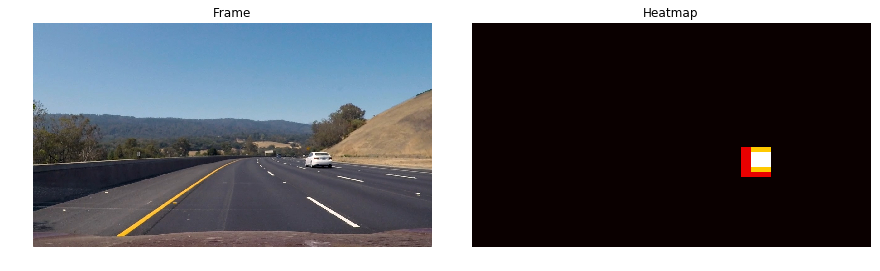

In [200]:
testImageHeat = np.zeros_like(testImage[:,:,0])
testImageHeat = addHeat(testImageHeat, rectangles)
# plt.figure(figsize=(10, 10))
# plt.imshow(testImageHeat, cmap='hot')
plotImages([testImage, testImageHeat], ['Frame', 'Heatmap'], cmap='hot')

## Apply Threshold to Remove Falsepositives

In [201]:
def applyThresh(image, thresh):
    image[image <= thresh] = 0
    return image

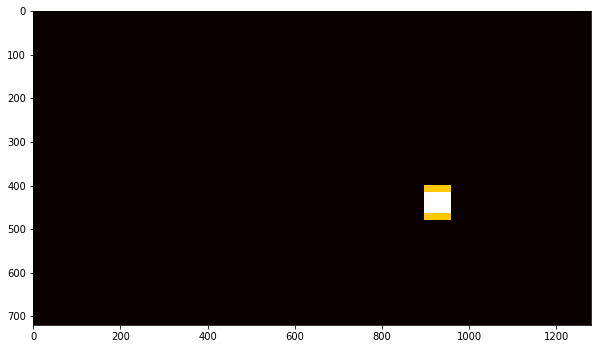

In [202]:
testImageHeat = applyThresh(testImageHeat, 1)
plt.figure(figsize=(10, 10))
plt.imshow(testImageHeat, cmap='hot')

## SciPy Labels

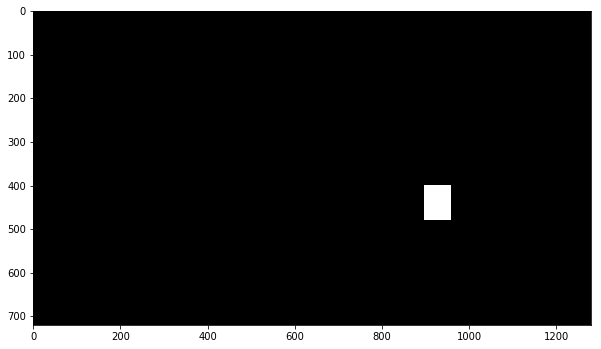

In [203]:
labels = label(testImageHeat)
plt.figure(figsize=(10, 10))
plt.imshow(labels[0], cmap='gray')
plt.savefig('test.png')

## Draw Boxes Based on Labels

In [204]:
def drawLabelBbox(image, labels):
    
    rectangles = []
    for i in range(1, labels[1]+1):
        nonzero = (labels[0] == i).nonzero()
        nonzeroY = np.array(nonzero[0])
        nonzeroX = np.array(nonzero[1])
        
        bbox = ((np.min(nonzeroX), np.min(nonzeroY)), (np.max(nonzeroX), np.max(nonzeroY)))
        rectangles.append(bbox)
        
        color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
        cv2.rectangle(image, bbox[0], bbox[1], color, 6)
    return image, rectangles

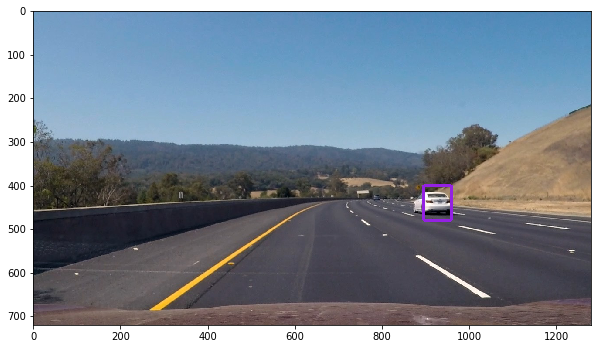

In [205]:
testImageLabel, rectangles = drawLabelBbox(testImage, labels)
plt.figure(figsize=(10, 10))
plt.imshow(testImageLabel)
plt.savefig('test.png')

In [107]:
class Store():
    def __init__(self):
        self.prevRects = []
        self.numSamples = 20
        
    def addRects(self, rects):
        self.prevRects.append(rects)
        if len(self.prevRects) > self.numSamples:
            del self.prevRects[0]

In [108]:
def processImage(image):
    
    cspace = 'YUV'
    orient = 11
    pixPerCell = 8
    cellPerBlock = 2
    hogChannel = 'all'


    yStart = 400
    yStop = 464
    scale = 1.0
    rectangles = detectCars(image, yStart, yStop, 
                            scale, cspace, hogChannel, 
                            svc, None, orient, 
                            pixPerCell, cellPerBlock, None, None)

    yStart = 416
    yStop = 480
    scale = 1.0
    rectangles += detectCars(image, yStart, yStop, 
                            scale, cspace, hogChannel, 
                            svc, None, orient, 
                            pixPerCell, cellPerBlock, None, None)

    yStart = 400
    yStop = 496
    scale = 1.5
    rectangles += detectCars(image, yStart, yStop, 
                            scale, cspace, hogChannel, 
                            svc, None, orient, 
                            pixPerCell, cellPerBlock, None, None)

    yStart = 432
    yStop = 528
    scale = 1.5
    rectangles += detectCars(image, yStart, yStop, 
                            scale, cspace, hogChannel, 
                            svc, None, orient, 
                            pixPerCell, cellPerBlock, None, None)

    yStart = 400
    yStop = 528
    scale = 2.0
    rectangles += detectCars(image, yStart, yStop, 
                            scale, cspace, hogChannel, 
                            svc, None, orient, 
                            pixPerCell, cellPerBlock, None, None)
    
    if rectangles:
        frameStore.addRects(rectangles)
        
    imageHeat = np.zeros_like(image[:,:,0])
    for rect in frameStore.prevRects:
        imageHeat = addHeat(imageHeat, rect)
    imageHeat = applyThresh(imageHeat, 1 + len(frameStore.prevRects)//2)
    
    labels = label(imageHeat)
    drawImage, _ = drawLabelBbox(image, labels)
    
    return drawImage

## Process Video

In [109]:
frameStore = Store()
videoOutputName = 'videoOutput.mp4'
videoInput = VideoFileClip('project_video.mp4')
processedVideo = videoInput.fl_image(processImage)
%time processedVideo.write_videofile(videoOutputName, audio=False)

[MoviePy] >>>> Building video videoOutput.mp4
[MoviePy] Writing video videoOutput.mp4


100%|█████████▉| 1260/1261 [13:46<00:00,  1.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videoOutput.mp4 

CPU times: user 24min 21s, sys: 1min 30s, total: 25min 51s
Wall time: 13min 48s
